In [1]:
"""
Summaries of USFS TreeMap linked to FIA plot data
Emphasis on 
    - Metrics of forest composition
    - Ecological gradients of species dominance
    - Forest structure (abundance, dominance, diversity, stand height)

Aggregate these statistics to FRP gridcells.

Author: maxwell.cook@colorado.edu
"""

import os, sys
import geopandas as gpd
import seaborn as sns
import xarray as xr

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

albers = 'EPSG:5070' # albers CONUS
utm = 'EPSG:32613' # UTM Zone 13N

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

print("Ready to go !")

Ready to go !


In [2]:
# load the aggregated FRP grids (regular 375m2 grids summarizing FRP from VIIRS)
fp = os.path.join(projdir,'data/spatial/mod/VIIRS/viirs_snpp_jpss1_afd_latlon_fires_pixar_gridstats.gpkg')
grid = gpd.read_file(fp)
print(f"\nThere are [{len(grid)}] grids across [{len(grid['Fire_ID'].unique())}] fires.\n")

# create a unique ID
grid['grid_idx'] = grid['Fire_ID'].astype(str) + grid['grid_index'].astype(str)

# add the centroid lat/lon to the grid data
df = grid.to_crs(4326) # WGS coords for lat/lon
df['x'] = df.geometry.centroid.x  # Longitude (x-coordinate)
df['y'] = df.geometry.centroid.y  # Latitude
grid = grid.merge(df[['grid_idx','x','y']], on='grid_idx', how='left')
del df
print(f"\n{grid.columns}\n")

# Drop any duplicate grids ...
print(f"Dropping [{grid.duplicated(subset=['grid_idx','Fire_ID']).sum()}] duplicate grids.\n")
grid = grid.drop_duplicates(subset=['grid_idx','Fire_ID'], keep='first')


There are [57232] grids across [100] fires.


Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95',
       'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp',
       'first_obs_date', 'last_obs_date', 't4_max', 't4_mean', 't5_max',
       't5_mean', 'day_count', 'night_count', 'frp_max_day', 'frp_max_night',
       'frp_csum_day', 'frp_csum_night', 'frp_mean_day', 'frp_mean_night',
       'frp_p90_day', 'frp_p90_night', 'frp_p95_day', 'frp_p95_night',
       'frp_p97_day', 'frp_p97_night', 'frp_p99_day', 'frp_p99_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fire_Name', 'geometry',
       'grid_idx', 'x', 'y'],
      dtype='object')

Dropping [0] duplicate grids.



Fractional overlap:
count    57232.000000
mean         2.023404
std          2.001402
min          0.000003
25%          0.587511
50%          1.493563
75%          2.771206
max         24.470760
Name: overlap, dtype: float64



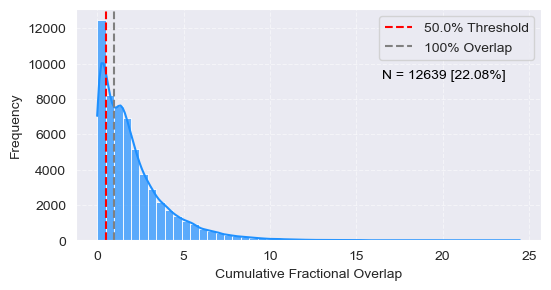

Plot saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/figures/grid_overlap_distribution.png
Dropping [12639 (22.08%)] grids with <50.0% fractional overlap.
44593


In [4]:
# Check out the distribution of grid overlap with FRP observations
thresh = 0.50
print(f"Fractional overlap:\n{grid['overlap'].describe()}\n")
n_small = grid[grid['overlap'] < thresh]['grid_idx'].count() 

# Plot the distribution of the fractional overlap
plt.figure(figsize=(6,3))
sns.histplot(grid['overlap'], kde=True, bins=50, color='dodgerblue', alpha=0.7)

# Add vertical line for the threshold and for 100%
plt.axvline(x=thresh, color='red', linestyle='--', label=f'{thresh*100}% Threshold')
plt.axvline(x=1, color='grey', linestyle='--', label='100% Overlap')

# Customize the plot
plt.xlabel('Cumulative Fractional Overlap')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.text(16.5, plt.ylim()[1] * 0.7, 
         f'N = {n_small} [{round(n_small/len(grid)*100,2)}%]', 
         fontsize=10, color='black')

# Save the plot
out_path = os.path.join(projdir, 'figures/grid_overlap_distribution.png')
plt.savefig(out_path, dpi=300, bbox_inches='tight')

plt.show()
print(f"Plot saved to: {out_path}")

# filter out grids below the overlap threshold
print(f"\nDropping [{n_small} ({round(n_small/len(grid)*100,2)}%)] grids with <{thresh*100}% fractional overlap.")
grid = grid[grid['overlap'] >= thresh] # remove these observations
print(len(grid))

## Gather LANDFIRE variables for the study region

LANDFIRE ca. 2016; [EVT, CC, CH, CBD, CBH, ]

In [ ]:
lf_vars = {
    'EVT': '',
    'CC': '',
    'CH': '',
    'CBD': '',
    'CBH': '',

}

In [5]:
# Load the TreeMap (ca. 2016)
# Pixel values here denote the FIA plot ID ("tm_id")
# see '04a_TreeMap_FIA-Prep.ipynb'
# fp = os.path.join(maindir,'data/landcover/USFS/RDS_TreeMap/TreeMap2016.tif') # tm_id band
fp = os.path.join(projdir, "data/spatial/mod/USFS/TreeMap_2016_TMID_FORTYPCD.tif") # multi-band
treemap_da = rxr.open_rasterio(fp, masked=True, cache=False).squeeze()
fortyp_da = treemap_da.sel(band=2) # the fortypcd band
# Grab some raster metadata from one of the layers
shp, gt, wkt, nd = fortyp_da.shape, fortyp_da.spatial_ref.GeoTransform, fortyp_da.rio.crs, fortyp_da.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {fortyp_da[0].dtype}")
del treemap_da # clean up
gc.collect()

Shape: (28724, 17006); 
GeoTransform: -1193295.0 30.0 0.0 2253345.0 0.0 -30.0; 
WKT: EPSG:5070; 
NoData Value: nan; 
Data Type: float32


141

In [6]:
# create a forest/non-forest grid
forest_mask = xr.where(~np.isnan(fortyp_da), 1, 0)
# calculate the grid-level forest percent
forest_pct = compute_band_stats(grid, forest_mask, 'grid_idx', attr='forest')
forest_pct.rename(columns={
    'pct_cover': 'forest_pct',
    'total_pixels': 'forest_pixels'
}, inplace=True)
print(forest_pct.head())
# retain just forest pixels
forest_pct = forest_pct[forest_pct['forest'] == 1] # just forest pixels
forest_pct = forest_pct[['grid_idx','forest_pixels','forest_pct']]

# how many forested grids are there? (>50%)
n_forest = len(forest_pct[forest_pct['forest_pct'] > 50])
print(f"\n[{round(n_forest/len(grid)*100,2)}%] predominantly forest grids.")
print(f"\n{forest_pct.head(3)}")

# Save as a GeoTIFF
out_fp = os.path.join(projdir, "data/spatial/mod/USFS/TreeMap_2016_forestmask.tif")
forest_mask.rio.to_raster(out_fp, compress='zstd', zstd_level=9, dtype='uint16', driver='GTiff')
print(f"Saved multi-band raster to: {out_fp}")

# save the grid
out_fp = os.path.join(projdir, "data/spatial/mod/USFS/grid_forestmask.gpkg")
grid_forest_pct = grid.merge(forest_pct, on="grid_idx", how="left")
grid_forest_pct.to_file(out_fp)
print(f"Saved grid to: {out_fp}")

del forest_mask
gc.collect() # clean up

    grid_idx  forest  count  forest_pixels  forest_pct
0  161955422       0     15            182    8.241758
1  161955422       1    167            182   91.758242
2  161957669       1    182            182  100.000000
3  161957670       1    196            196  100.000000
4  161957671       1    182            182  100.000000

[89.01%] predominantly forest grids.

    grid_idx  forest_pixels  forest_pct
1  161955422            182   91.758242
2  161957669            182  100.000000
3  161957670            196  100.000000
Saved multi-band raster to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/USFS/TreeMap_2016_forestmask.tif
Saved grid to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/USFS/grid_forestmask.gpkg


16

## Algorithmic Forest Type Code

Summary of the TreeMap Algorithmic Forest Type Code (FORTYPCD) within FRP grids. 

In [7]:
# also calculate the FORTYPCD
t0 = time.time()

# see __functions.py
grid_fortypcd = compute_band_stats(grid, fortyp_da, 'grid_idx', attr='fortypcd')

# tidy columns in the summary table
grid_fortypcd['count'] = grid_fortypcd['count'].astype(int)
grid_fortypcd['total_pixels'] = grid_fortypcd['total_pixels'].astype(int)
grid_fortypcd.rename(columns = {'count': 'fortyp_pixels'}, inplace=True)

# load the species lookup table
fp = os.path.join(projdir,'data/tabular/mod/treemap_fortypcd_species_mapping.csv')
species_df = pd.read_csv(fp)
species_df = species_df[['FORTYPCD','SpeciesName']]
species_df.rename(columns={
    'FORTYPCD': 'fortypcd',
    'SpeciesName': 'fortypnm'
}, inplace=True)

# join the forest name
grid_fortypcd = grid_fortypcd.merge(species_df, on='fortypcd', how='left')
print(f"\n{grid_fortypcd.head(3)}")

t1 = (time.time() - t0) / 60
print(f"\nTotal elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

del fortyp_da, species_df # clean up 
gc.collect()


    grid_idx  fortypcd  fortyp_pixels  total_pixels  pct_cover  \
0  161955422       182             17           167  10.179641   
1  161955422       201             38           167  22.754491   
2  161955422       221             26           167  15.568862   

                 fortypnm  
0  Rocky Mountain juniper  
1             Douglas-fir  
2          Ponderosa pine  

Total elapsed time: 0.54 minutes.

~~~~~~~~~~



44

In [8]:
grid_fortypcd['fortypnm'].unique()

array(['Rocky Mountain juniper', 'Douglas-fir', 'Ponderosa pine',
       'White fir', 'Grand fir', 'Blue spruce', 'Lodgepole pine',
       'Western juniper', 'California mixed conifer', 'Aspen',
       'Deciduous oak woodland', 'Nonstocked', 'Engelmann spruce',
       'Western larch', 'Pinyon / juniper woodland', 'Subalpine fir',
       'Engelmann spruce / subalpine fir', 'Limber pine', 'Jeffrey pine',
       'Other hardwoods', 'Juniper woodland',
       'Intermountain maple woodland', 'Pin cherry', 'Bur oak',
       'Cercocarpus (mountain brush) woodland',
       'Foxtail pine / bristlecone pine', 'Southwestern white pine',
       'California black oak', 'Cottonwood', 'Cottonwood / willow',
       'Sugar maple / beech / yellow birch',
       'Eastern redcedar / hardwood',
       'Sugarberry / hackberry / elm / green ash', 'Mesquite woodland',
       'Miscellaneous woodland hardwoods', 'Elm / ash / black locust',
       'Other exotic hardwoods', 'Evergreen oak woodland', 'Willow',
    

In [9]:
# list the Southern Rockies species
srm_spps = [
    'ponderosa pine', 'douglas-fir', 'white fir',
    'limber pine', 'blue spruce', 'foxtail pine / bristlecone pine',
    'engelmann spruce / subalpine fir', 'engelmann spruce', 'subalpine fir',
    'lodgepole pine', 'aspen', 'rocky mountain juniper', 'pinyon / juniper woodland', 
    'juniper woodland', 'deciduous oak woodland'
]

# filter to retain Southern Rockies species
grid_fortypcd['fortypnm'] = grid_fortypcd['fortypnm'].str.lower()  # force to lower case
grid_fortypcd = grid_fortypcd[grid_fortypcd['fortypnm'].isin(srm_spps)].copy()
print(grid_fortypcd['fortypnm'].unique())

['rocky mountain juniper' 'douglas-fir' 'ponderosa pine' 'white fir'
 'blue spruce' 'lodgepole pine' 'aspen' 'deciduous oak woodland'
 'engelmann spruce' 'pinyon / juniper woodland' 'subalpine fir'
 'engelmann spruce / subalpine fir' 'limber pine' 'juniper woodland'
 'foxtail pine / bristlecone pine']


In [10]:
grid_fortypcd.columns

Index(['grid_idx', 'fortypcd', 'fortyp_pixels', 'total_pixels', 'pct_cover',
       'fortypnm'],
      dtype='object')

In [11]:
grid_fortypcd['pct_cover'].describe()

count    229854.000000
mean         18.160672
std          25.145113
min           0.510204
25%           1.666667
50%           6.043956
75%          23.469388
max         100.000000
Name: pct_cover, dtype: float64

In [12]:
# filter out very small percent covers (<1%)
grid_fortypcd = grid_fortypcd[(grid_fortypcd['pct_cover'] > 1)]
grid_fortypcd.reset_index(inplace=True)
# Check results
print(f"\n{grid_fortypcd[['grid_idx','fortypnm','pct_cover']].head(15)}\n")


     grid_idx                fortypnm  pct_cover
0   161955422  rocky mountain juniper  10.179641
1   161955422             douglas-fir  22.754491
2   161955422          ponderosa pine  15.568862
3   161955422               white fir  13.173653
4   161955422             blue spruce   5.389222
5   161955422          lodgepole pine   4.191617
6   161955422                   aspen   5.988024
7   161955422  deciduous oak woodland   1.197605
8   161957669             douglas-fir  29.670330
9   161957669          ponderosa pine  31.318681
10  161957669                   aspen   6.043956
11  161957670  rocky mountain juniper   5.612245
12  161957670             douglas-fir   9.183673
13  161957670          ponderosa pine  34.183673
14  161957670        engelmann spruce   1.020408



In [13]:
# calculate the species co-occurrence matrix
# see __functions.py
coo_mat, coo_pct = get_spp_coo(
    grid_fortypcd, 
    grid_col='grid_idx', 
    sp_col='fortypnm', 
)


Species occurrence counts:
fortypnm
ponderosa pine                      28793
lodgepole pine                      27565
aspen                               23580
douglas-fir                         20219
engelmann spruce / subalpine fir    16480
rocky mountain juniper              14035
deciduous oak woodland              13414
engelmann spruce                    12122
pinyon / juniper woodland           11590
subalpine fir                       11210
white fir                           10732
juniper woodland                     3470
limber pine                          2849
blue spruce                          1600
foxtail pine / bristlecone pine       614
Name: count, dtype: int64



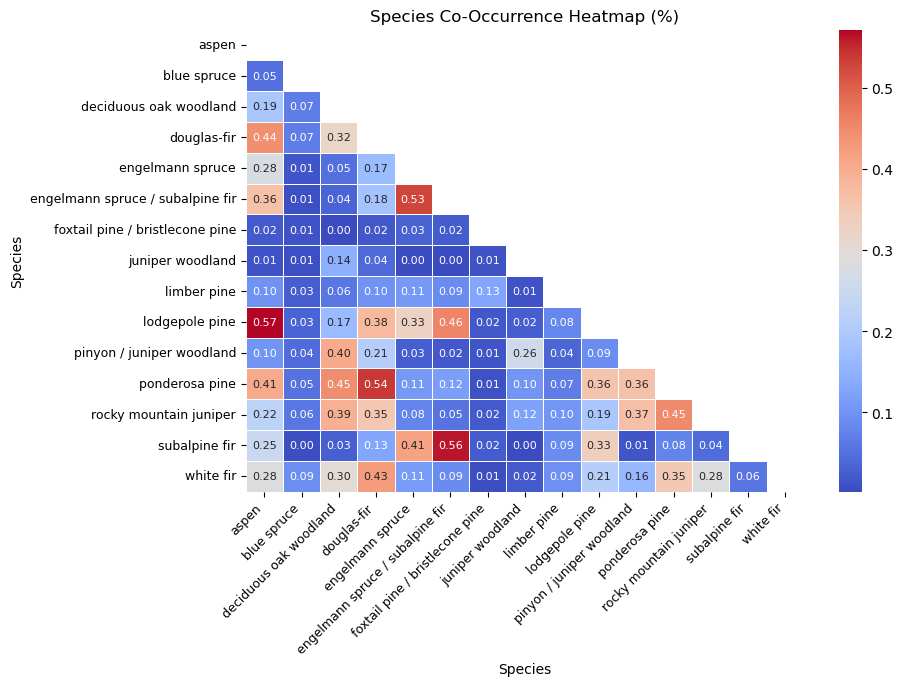

In [14]:
# Mask diagonal values (optional)
mask = np.triu(np.ones_like(coo_pct, dtype=bool))
# Plot heatmap
plt.figure(figsize=(9, 6))
sns.heatmap(coo_pct, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5, mask=mask, annot_kws={"size": 8})
# Improve readability
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.title("Species Co-Occurrence Heatmap (%)", fontsize=12)
plt.xlabel("Species", fontsize=10)
plt.ylabel("Species", fontsize=10)
plt.show()

del coo_pct, coo_mat, mask



Species making up 99% of the total: 

                            fortypnm  fortyp_pixels  fraction  c_fraction
9                     lodgepole pine        1801682  0.277404    0.277404
11                    ponderosa pine        1716157  0.264236    0.541640
0                              aspen         736847  0.113452    0.655092
5   engelmann spruce / subalpine fir         677046  0.104245    0.759337
3                        douglas-fir         410428  0.063193    0.822530
10         pinyon / juniper woodland         292862  0.045092    0.867622
4                   engelmann spruce         222780  0.034301    0.901924
13                     subalpine fir         164865  0.025384    0.927308
14                         white fir         144225  0.022206    0.949514
12            rocky mountain juniper         133341  0.020530    0.970045
2             deciduous oak woodland         128643  0.019807    0.989852




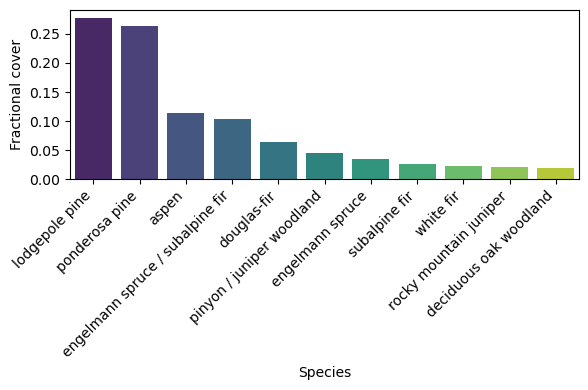

13941

In [15]:
# Create a histogram of the forest species (prevalence)
fortyp = grid_fortypcd.copy() # make a copy to work with
# calculate the landscape fraction (prevalence)
spp_pr = fortyp.groupby('fortypnm')['fortyp_pixels'].sum().reset_index()
spp_pr['fraction'] = spp_pr['fortyp_pixels'] / spp_pr['fortyp_pixels'].sum()
spp_pr = spp_pr.sort_values(by='fraction', ascending=False)
# which species make up 97% of observations?
spp_pr['c_fraction'] = spp_pr['fraction'].cumsum()
top_species = spp_pr[spp_pr['c_fraction'] <= 0.99]
print(f"\n\nSpecies making up 99% of the total: \n\n{top_species}\n\n")

# plot it
plt.figure(figsize=(6, 4))
sns.barplot(data=top_species, x='fortypnm', y='fraction', palette='viridis')
plt.xlabel('Species')
plt.ylabel('Fractional cover')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# clean up
del fortyp, spp_pr
gc.collect()

In [16]:
# Retain only the top species
grid_fortypcd = grid_fortypcd[grid_fortypcd['fortypnm'].isin(top_species['fortypnm'].unique())]
# Aggregate species into forest groups
# These groups represent common pairings for the Southern Rockies
spp_grouping = {
    'pinyon|juniper': 'Piñon-juniper',
    'engelmann|subalpine': 'Spruce-fir',
    'ponderosa pine': 'Ponderosa pine', 
    'lodgepole pine': 'Lodgepole pine',
    'aspen': 'Quaking aspen',
    'douglas-fir': 'Douglas-fir',
    'white fir': 'White fir',
    'deciduous oak woodland': 'Gambel oak',
}

# create the remap table
spp_remap = {} # dictionary to store the remap values
# Iterate over groups to create the species remap dictionary
for keywords, spp_group in spp_grouping.items():
    # Find species matching the keywords
    spp = grid_fortypcd[grid_fortypcd['fortypnm'].str.contains(keywords, case=False, na=False)]
    # Add matching species to the remap dictionary
    spp_remap.update(
        {name: spp_group for name in spp['fortypnm'].unique()}
    )
    del spp
    
# Apply the remap to create a new grouped species column
grid_fortypcd['fortypnm_gp'] = grid_fortypcd['fortypnm'].map(spp_remap).fillna(grid_fortypcd['fortypnm'])
# Verify the updated species groups
print(grid_fortypcd[['grid_idx', 'fortypnm', 'fortypnm_gp', 'pct_cover']].drop_duplicates().head(8))
print(f"\n{grid_fortypcd.columns}")

    grid_idx                fortypnm     fortypnm_gp  pct_cover
0  161955422  rocky mountain juniper   Piñon-juniper  10.179641
1  161955422             douglas-fir     Douglas-fir  22.754491
2  161955422          ponderosa pine  Ponderosa pine  15.568862
3  161955422               white fir       White fir  13.173653
5  161955422          lodgepole pine  Lodgepole pine   4.191617
6  161955422                   aspen   Quaking aspen   5.988024
7  161955422  deciduous oak woodland      Gambel oak   1.197605
8  161957669             douglas-fir     Douglas-fir  29.670330

Index(['index', 'grid_idx', 'fortypcd', 'fortyp_pixels', 'total_pixels',
       'pct_cover', 'fortypnm', 'fortypnm_gp'],
      dtype='object')


In [17]:
# Aggregate with the new species groupings
# Reacalculate the percent cover for each species group
grid_fortypgp = (
    grid_fortypcd.groupby(['grid_idx','fortypnm_gp'], as_index=False)
    .agg(
        fortyp_pixels=('fortyp_pixels','sum'),
        total_pixels=('total_pixels','max'),
        fortyp_pct=('pct_cover','sum'),
    )
)

# Merge in the forest percent
grid_fortypgp = grid_fortypgp.merge(forest_pct, on='grid_idx', how='inner')
# Reclaculate the fortyp_pct as the percent of forested pixels
grid_fortypgp['fortyp_pct'] = grid_fortypgp['fortyp_pixels'] / grid_fortypgp['forest_pixels']

# Check on nulls introduced
print(f"\nNaNs in FORTYP group name: {grid_fortypgp['fortypnm_gp'].isna().sum()}\n")
print(f"Forest percent:\n{grid_fortypgp['forest_pct'].describe()}\n")
print(f"\n{grid_fortypgp.head(10)}\n")
print("\n~~~~~~~~~~~~~~~~~~\n")

del grid_fortypcd, forest_pct
gc.collect()


NaNs in FORTYP group name: 0

Forest percent:
count    162652.000000
mean         85.994587
std          22.592656
min           0.510204
25%          81.868132
50%          97.633136
75%         100.000000
max         100.000000
Name: forest_pct, dtype: float64


  grid_idx     fortypnm_gp  fortyp_pixels  total_pixels  fortyp_pct  \
0  0819725     Douglas-fir              1            73    0.005495   
1  0819725   Piñon-juniper              1            73    0.005495   
2  0819725   Quaking aspen             55            73    0.302198   
3  0819725      Spruce-fir              7            73    0.038462   
4  0819725       White fir              2            73    0.010989   
5  0821970   Quaking aspen            119           158    0.653846   
6  0821970      Spruce-fir             34           158    0.186813   
7  0821974     Douglas-fir             15           164    0.082418   
8  0821974      Gambel oak              2           164    0.010989   
9  0821974  Ponderosa pi

5004

In [18]:
# Filter out very small percentages again:
# This is needed because we re-calculated the percent cover using the forested pixels
print(f"Before filtering: {len(grid_fortypgp)}\n")
grid_fortypgp = grid_fortypgp[grid_fortypgp['fortyp_pct'] > 0.01]
print(f"After filtering: {len(grid_fortypgp)}\n")

Before filtering: 162652

After filtering: 159165



In [20]:
# check for duplicates, remove them
n = grid_fortypgp.duplicated(subset=['grid_idx','fortypnm_gp','fortyp_pct']).sum()
if n > 0:
    print(f"\nDropping [{n}] duplicate rows.\n")
    grid_fortypgp = grid_fortypgp.drop_duplicates(subset=['grid_idx','fortypnm_gp','fortyp_pct'])
else:
    print("\nNo duplicates at this stage.\n")


No duplicates at this stage.





Species making up 97% of the total: 

      fortypnm_gp  fortyp_pixels  fraction  dom_count  dom_fraction  \
2  Lodgepole pine        1801129  0.280314      11957      0.269837   
4  Ponderosa pine        1715827  0.267039      14545      0.328241   
6      Spruce-fir        1064387  0.165653       6514      0.147003   
5   Quaking aspen         736503  0.114624       5074      0.114506   
3   Piñon-juniper         425632  0.066242       3052      0.068875   
0     Douglas-fir         409958  0.063803       2281      0.051476   
7       White fir         143937  0.022401        464      0.010471   
1      Gambel oak         128016  0.019923        425      0.009591   

   c_fraction  
2    0.280314  
4    0.547353  
6    0.713006  
5    0.827630  
3    0.893872  
0    0.957675  
7    0.980077  
1    1.000000  




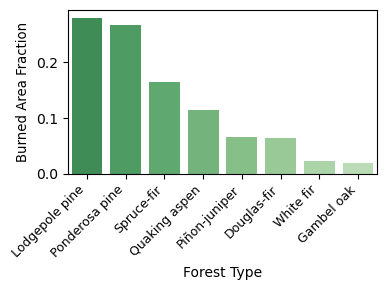

In [64]:
# Re-create the histogram of forest species (prevalence)
df = grid_fortypgp.copy() # make a copy to work with

# calculate the landscape fraction (prevalence)
spp_pr = df.groupby('fortypnm_gp')['fortyp_pixels'].sum().reset_index()
spp_pr['fraction'] = spp_pr['fortyp_pixels'] / spp_pr['fortyp_pixels'].sum()

# calculate the fraction of gridcells for each primary type
primary = (
    df.loc[df.groupby('grid_idx')['fortyp_pct'].idxmax()]
    .copy()
)

# Count how many times each forest type is primary
primary_n = (
    primary.groupby('fortypnm_gp')['grid_idx']
    .nunique()
    .reset_index(name='dom_count')
)

# Step 3: Normalize to get the fraction of all grid cells
total_grids = df['grid_idx'].nunique()
primary_n['dom_fraction'] = primary_n['dom_count'] / total_grids

# Merge the dominance fraction into the species prevalence table
spp_pr = spp_pr.merge(primary_n, on='fortypnm_gp', how='left').fillna(0)
spp_pr = spp_pr.sort_values(by='fraction', ascending=False)
# which species make up 97% of observations?
spp_pr['c_fraction'] = spp_pr['fraction'].cumsum()
top_species = spp_pr[(spp_pr['c_fraction'] <= 0.97) | (spp_pr['fraction'] > 0.01)]
print(f"\n\nSpecies making up 97% of the total: \n\n{top_species}\n\n")

# Plot the landscape fraction as bars

plt.figure(figsize=(4, 3))

# function to truncate a color palette
def truncate_cmap(cmap_name, min_val=0.2, max_val=0.8, n_colors=10):
    cmap = cm.get_cmap(cmap_name)
    truncated = cmap(np.linspace(min_val, max_val, n_colors))
    return [tuple(rgb[:3]) for rgb in truncated]

# apply this to the greens palette
palette = truncate_cmap("Greens_r", 0.3, 0.8)

bar_width = 0.8
sns.barplot(
    data=top_species, 
    x='fortypnm_gp', 
    y='fraction', 
    palette=palette, 
    # color='#41ab5d',
    alpha=0.98)

# Add labels and formatting
plt.xlabel('Forest Type', size=10)
plt.ylabel('Burned Area Fraction', size=9.5)
plt.xticks(ticks=range(len(top_species)), 
           labels=top_species['fortypnm_gp'], 
           rotation=45, ha='right',
           size=9)
# plt.legend(loc='upper right')
plt.tight_layout()

# Save the map
out_png = os.path.join(projdir, 'figures/FigureS1_TopSpecies.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

# del df, spp_pr
# gc.collect()

In [ ]:
# check on all the species remaining
spps = top_species['fortypnm_gp'].unique()
spps

## TreeMap Gridcell-level Canopy % and BALIVE

In [ ]:
# Subset the spatial data
grid_ = grid[grid['grid_idx'].isin(grid_fortypgp['grid_idx'].unique())]
print(f"Number of grids in the filtered subset: {len(grid_)}")
del grid

In [ ]:
# Load the TreeMap Canopy % 
canopypct = os.path.join(projdir, "data/spatial/raw/USFS/TreeMap/treemap_west_canopypct.tif") 
canopypct = rxr.open_rasterio(canopypct, cache=False).squeeze()
# Grab some raster metadata from one of the layers
shp, gt, wkt, nd = canopypct.shape, canopypct.spatial_ref.GeoTransform, canopypct.rio.crs, canopypct.rio.nodata
print(
    f"\nShape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {canopypct[0].dtype}\n")

# Calculate the mean grid-level canopy percent
canopypct_mn = compute_band_stats(
    geoms=grid_, 
    image_da=canopypct, 
    id_col='grid_idx', 
    attr='canopypct', 
    stats=['mean'], # calculate the mean canopy pct
    ztype='continuous'
)
del canopypct

print(canopypct_mn.head())

In [ ]:
# Load the TreeMap BALIVE
balive = os.path.join(projdir, "data/spatial/raw/USFS/TreeMap/treemap_west_balive.tif") 
balive = rxr.open_rasterio(balive, masked=True, cache=False).squeeze()
# Grab some raster metadata from one of the layers
shp, gt, wkt, nd = balive.shape, balive.spatial_ref.GeoTransform, balive.rio.crs, balive.rio.nodata
print(
    f"\nShape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {balive[0].dtype}\n")

# Calculate the mean grid-level canopy percent
balive_sum = compute_band_stats(
    geoms=grid_, 
    image_da=balive, 
    id_col='grid_idx', 
    attr='balive', 
    stats=['sum'],
    ztype='continuous'
)

del balive

# Merge the canopy percent and BALIVE
grid_metrics = pd.merge(canopypct_mn, balive_sum, on="grid_idx", how="inner")
print(grid_metrics.head())

del canopypct_mn, balive_sum

# Merge to the forest type dataframe
grid_fortypgp_f = pd.merge(grid_fortypgp, grid_metrics, on="grid_idx", how="left")
print(f"\n{grid_fortypgp_f.columns}\n")

In [ ]:
grid_fortypgp_f[['grid_idx','fortypnm_gp','fortyp_pct','canopypct_mean','balive_sum']].head()

In [ ]:
len(grid_fortypgp_f)

## LANDFIRE Forest Canopy Cover and Height

In [ ]:
# list out the landfire GeoTIFFs
# veg Type, Height, and Cover
lf_dir = os.path.join(projdir,'data/spatial/mod/LANDFIRE/')
lf_tiffs = list_files(lf_dir, '*.tif', recursive=True)
lf_tiffs = [f for f in lf_tiffs if any(sub in f for sub in ['cc', 'ch'])]
print([os.path.basename(f) for f in lf_tiffs])

In [ ]:
# calculate the continuous summaries (forest canopy percent and height)
ccs = {
    'lf_forest_cc': lf_tiffs[0],
    'lf_forest_ch': lf_tiffs[1]
}
results = [] # store results
for key, fp in ccs.items():
    print(f"Processing: {os.path.basename(fp)}")
    da = rxr.open_rasterio(fp, masked=True, cache=False).squeeze()
    # calculate zonal statistics
    zs = compute_band_stats(
        geoms=grid_, 
        image_da=da, 
        id_col='grid_idx', 
        stats=['mean'], 
        attr=key,
        ztype='continuous'
    )
    results.append(zs)
    del da, zs

# concatenate the results
fc_summary = pd.concat([df.set_index("grid_idx") for df in results], axis=1).reset_index()
fc_summary.head()

In [ ]:
# save the TreeMap FORTYPCD table out.
# merge in the LANDFIRE canopy cover and height
grid_fortypgp_fc = pd.merge(grid_fortypgp_f, fc_summary, on='grid_idx', how='left')
# save the file out
out_fp = os.path.join(projdir,'data/tabular/mod/gridstats_fortypnm_gp_fc.csv')
grid_fortypgp_fc[[
    'grid_idx', 'fortypnm_gp', 'fortyp_pct', 
    'canopypct_mean', 'balive_sum', 'forest_pct',
    'lf_forest_cc_mean', 'lf_forest_ch_mean'
]]
grid_fortypgp_fc.to_csv(out_fp)
print(f"Saved file to: {out_fp}")

gc.collect()

## Plots of forest type

In [ ]:
# subset the grids to predominantly forested plots (>50% forested)
# Just work with forested grids from here on out:
grid_forest = grid_fortypgp[grid_fortypgp['forest_pct'] > 50]
n_forest = len(grid_forest['grid_index'].unique())
print(f"{n_forest}/{len(grid)} [{round(n_forest/len(grid)*100,1)}%] gridcells are >50% forested.")

In [ ]:
# plot the distribution of percent cover by forest types
df = grid_fortypgp.copy()
df['fortypnm_gp'] = df['fortypnm_gp'].astype('category')
species_order = top_species['fortypnm_gp'].tolist()
df['fortypnm_gp'] = pd.Categorical(
    df['fortypnm_gp'],
    categories=species_order,
    ordered=True
)

# Create a FacetGrid with the specified order
g = sns.FacetGrid(
    data=df,
    col='fortypnm_gp',      
    col_wrap=3,             
    sharex=False,            
    sharey=False,            
    height=2,               
    aspect=1.2              
)

# Map a KDE plot to each facet
g.map(sns.kdeplot, 'pct_cover', fill=True, alpha=0.6)
# Customize the plot
g.set_titles("{col_name}")  # Use species names as titles
g.set_axis_labels("Percent Cover (%)", "Density", size=8)  # Axis labels
g.fig.set_size_inches(6,4)  # Set figure dimensions
plt.subplots_adjust(top=0.9)  # Adjust subplot spacing

del df
gc.collect()

plt.show()

In [ ]:
grid_fortypgp.columns

In [ ]:
grid_fortypgp['fortypnm_gp'].isna().sum()

In [ ]:
print(len(grid_fortypgp))
print(len(grid))

In [ ]:
# join the forest type dataframe to our FRP gridcells
grid_frp = grid.merge(grid_fortypgp, on='grid_index', how='inner')
print(grid_frp.columns)
print(len(grid_frp))

# tidy up
del grid_forest
gc.collect()

In [ ]:
print(f"\nDropping [{grid_frp['fortypnm_gp'].isna().sum()}] NaN rows.\n")
grid_frp = grid_frp[~grid_frp['fortypnm_gp'].isna()]
print(len(grid_frp))

In [ ]:
print(f"\nSubsetting to top species groups:\n{top_species['fortypnm_gp'].unique()}")
grid_frp = grid_frp[grid_frp['fortypnm_gp'].isin(top_species['fortypnm_gp'].unique())]
print(f"\n{len(grid_frp['grid_index'].unique())}/{len(grid['grid_index'].unique())}")

In [ ]:
# make some plots showing the distribution of FRP across forest types
# gather the dominant forest type
dfortyp = grid_frp.loc[grid_frp.groupby('grid_index')['pct_cover'].idxmax()]
print(dfortyp['fortypnm_gp'].unique())
print("\n")

# Retain only the daytime FRP measurements
n_small = len(dfortyp[dfortyp['frp_max_day'] == 0]) 
print(f"Dropping {n_small} [{round(n_small/len(dfortyp)*100,1)}%] gridcells w/ >0 max daytime FRP.")
dfortyp = dfortyp[(dfortyp['frp_max_day'] > 0)]

# create a dataframe with dominance (>90% of the same species)
dom = dfortyp[dfortyp['pct_cover'] > 50]
# Plot FRP by dominant forest type
# Find the median and sort the forest types by FRP
med = dom.groupby('fortypnm_gp')['frp_max_day'].median().sort_values(ascending=False)
sorted = med.index.tolist()

# setup the plot
plt.figure(figsize=(6, 4)) 

# boxplot
sns.boxplot(
    data=dom, 
    x='frp_max_day', 
    y='fortypnm_gp', 
    order=sorted, 
    palette='coolwarm_r', 
    fliersize=4,
    dodge=False)

# adjust plot elements
plt.xscale('log') # log-scale FRP
plt.xlabel('Daytime Fire Radiative Power (FRP)')
plt.ylabel('Forest Type')
plt.tight_layout()
# save it out.
out_plot = os.path.join(projdir, 'figures/FigureX_FORTYPCD_DominantSpecies_FRPmax_gp.png')
plt.savefig(out_plot, dpi=300, bbox_inches='tight')

plt.show()
print(f"\nSaved to: {out_plot}\n")

In [ ]:
# Run a statistical test between these groups
from scipy.stats import kruskal
import scikit_posthocs as sp

# Group FRP by forest type
grouped_frp = [dom[dom['fortypnm_gp'] == f]['frp_max_day'].values for f in sorted]
# Perform Kruskal-Wallis test
stat, p = kruskal(*grouped_frp)
print(f"\nKruskal-Wallis Test: H={stat:.3f}, p={p:.3e}\n")

# Dunn's test for pairwise comparisons
dunn = sp.posthoc_dunn(
    dom, val_col='frp_max_day', group_col='fortypnm_gp', p_adjust='bonferroni'
)
print(f"Dunn's test:\n{dunn}")
print("\n~~~~~~~~~~~~~~~~~\n")

del grouped_frp, stat, p, dunn
gc.collect()

In [ ]:
# Plot the Day vs. Night max FRP for dominant types
dom = dom[dom['frp_max_day'] > 0]
dom = dom[dom['frp_max_night'] > 0]

# Reshape the data to long format for both day and night FRP
dom_l = pd.melt(
    dom, 
    id_vars=['fortypnm_gp'], 
    value_vars=['frp_max_day', 'frp_max_night'], 
    var_name='DayNight', 
    value_name='FRP'
)

# Map `Time` values for clearer labels
dom_l['DayNight'] = dom_l['DayNight'].map({
    'frp_max_day': 'Day', 
    'frp_max_night': 'Night'
})

# Create the plot
plt.figure(figsize=(6, 4))

sns.boxplot(
    data=dom_l,
    x="FRP",
    y="fortypnm_gp",
    hue="DayNight",
    order=sorted,
    palette='magma_r',
    fliersize=3,
)

plt.xscale('log')  # Log-scale FRP
plt.xlabel('Fire Radiative Power (FRP)', fontsize=11)
plt.ylabel('Forest Type', fontsize=11)
plt.legend(title='', loc='lower right', fontsize=9)
plt.tight_layout()

# Save and show the plot
out_plot = os.path.join(projdir, 'figures/FigureX_FORTYPCD_DominantSpecies_FRPmax_DayNight_gp.png')
plt.savefig(out_plot, dpi=300, bbox_inches='tight')
plt.show()

print(f"\nSaved to: {out_plot}\n")

In [ ]:
# save the table out.
out_fp = os.path.join(projdir,'data/tabular/mod/gridstats_fortypnm_gp_forest_frp.csv')
grid_frp.to_csv(out_fp)
print(f"Saved file to: {out_fp}")

In [ ]:
# Identify gridcells with some aspen component
aspen_idx = grid_frp[grid_frp['fortypnm_gp'] == 'Quaking aspen']['grid_index'].unique() # list of grid indices
grid_aspen = grid_frp[grid_frp['grid_index'].isin(aspen_idx)]
# check how many aspen gridcells there are
n_aspen = len(grid_aspen['grid_index'].unique())
print(f"{n_aspen} [{round(n_aspen/len(grid_frp['grid_index'].unique())*100,1)}%] gridcells with some aspen component.")

In [ ]:
# waffle chart version
# create bins for species composition
bins = np.linspace(0, 100, 6) # 20% intervals
spps = [s for s in grid_aspen['fortypnm_gp'].unique() if s != 'Quaking aspen'] # exclude aspen from species list
print(f"Associate forest type: {spps}\n")

# create grid data
df = grid_aspen.copy() # work from a copy
tiles = []  # Store tile data
for sp in spps:
    # Filter for co-occurrence
    df_sp = df[df['fortypnm_gp'].isin(['Quaking aspen', sp])]
    # Pivot to create columns for Aspen and the species
    cover_df = (
        df_sp.pivot_table(
            index='grid_index', 
            columns='fortypnm_gp', 
            values='pct_cover', 
            fill_value=0
        ).reset_index()
         .rename(columns={'Quaking aspen': 'aspen_cover', sp: f'{sp}_cover'})
    )
    # Make sure there are some of each species (aspen and other)
    cover_df['combined_cover'] = cover_df['aspen_cover'] + cover_df[f'{sp}_cover']
    cover_df = cover_df[cover_df['combined_cover'] >= 50] # where one or both make up the majority
    # Merge back with FRP data
    cover_df = cover_df.merge(
        grid_aspen[['grid_index','frp_max_day', 'frp_max_night']].drop_duplicates(), 
        on='grid_index', how='left')

    # Bin Aspen and species percent cover
    cover_df['aspen_bin'] = pd.cut(cover_df['aspen_cover'], bins, labels=range(len(bins) - 1))
    cover_df[f'{sp}_bin'] = pd.cut(cover_df[f'{sp}_cover'], bins, labels=range(len(bins) - 1))
    # Group by bins and calculate statistics
    grouped = cover_df.groupby(['aspen_bin', f'{sp}_bin'])
    counts = grouped.size().reset_index(name='freq')  # Frequency for tile size
    mean_frp = grouped['frp_max_day'].mean().reset_index(name='frp')  # Mean FRP for color

    # Merge statistics into a single DataFrame
    tiled_data = pd.merge(counts, mean_frp, on=['aspen_bin', f'{sp}_bin'])
    tiled_data['species'] = sp
    tiles.append(tiled_data)

    # Tidy up
    del df_sp, cover_df, grouped, counts, mean_frp, tiled_data
    gc.collect()

# Combine tile data
tiles_df = pd.concat(tiles, ignore_index=True)
tiles_df['log_frp'] = np.log10(tiles_df['frp'] + 1e-6) # add a small value to help with log-scaling

# Normalize tile sizes (scale frequency)
tiles_df['tile_size'] = (tiles_df['freq'] / tiles_df['freq'].max()) ** 0.2  # Square root scaling for better size balance

# Plotting the tile-scaled heatmap
n_cols = 3  # Number of columns in the facet grid
n_rows = int(np.ceil(len(spps) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10,6), constrained_layout=True)
axes = axes.flatten()

# handle the normalization
vmin = tiles_df['log_frp'].min()
vmax = tiles_df['log_frp'].quantile()
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)  # Define color normalization based on raw FRP range

# log_frp_min = np.percentile(tiles_df['log_frp'], 10)
# log_frp_max = np.percentile(tiles_df['log_frp'], 90)

# make the grids
for i, sp in enumerate(spps):
    sp_data = tiles_df[tiles_df['species'] == sp]
    ax = axes[i]

    vmin = sp_data['frp'].min()
    vmax = sp_data['frp'].max()

    for _, row in sp_data.iterrows():
        x = int(row[f'{sp}_bin'])  
        y = int(row['aspen_bin'])  
        size = row['tile_size'] * 0.9
        
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
        color = plt.cm.coolwarm(norm(row['frp']))
        
        ax.add_patch(
            plt.Rectangle(
                (x - size / 2, y - size / 2), size, size, color=color, ec='black', lw=0.5
            )
        )

    # Formatting the axes
    # ax.set_title(sp, size=10)
    ax.text(
        0.95, 0.95, sp,  # x, y position in axis coordinates (top-right corner)
        transform=ax.transAxes,  # Use axis coordinates (0,0 is bottom-left, 1,1 is top-right)
        ha='right', va='top',  # Align the text to the top-right
        fontsize=10, color='black', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2')
    )
    ax.set_xlabel(f'')
    ax.set_ylabel('Aspen Cover (%)', size=9)
    ax.set_xticks(range(len(bins) - 1))
    ax.set_yticks(range(len(bins) - 1))
    ax.set_xticklabels([f'{int(b)}%' for b in bins[:-1]], size=8)
    ax.set_yticklabels([f'{int(b)}%' for b in bins[:-1]], size=8)
    ax.set_xlim(-0.5, len(bins) - 1.5)
    ax.set_ylim(-0.5, len(bins) - 1.5)

sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=norm)
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.05, pad=0.02)
cbar.set_label('Maximum FRP')
# cbar.set_label('Cumulative FRP', fontsize=10)
cbar.ax.tick_params(labelsize=8)

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

del df

out_plot = os.path.join(projdir, 'figures/FigureX_CoOccurring_Heatmap_FRPmax_Scaled_gp.png')
plt.savefig(out_plot, dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
gc.collect()